The Horses vs. humans dataset from Kaggle has been used for this project. The entire dataset has been generated using CGI by Laurence Moroney. The images in the dataset are 300x300. 
The InceptionV3 network from keras api has been used by Transfer learning. 
For more information, visit : https://keras.io/api/applications/inceptionv3/

In [34]:
#importing necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
import matplotlib.pyplot as plt

The following code block creates an instance of the InceptionV3 network and freezes the model.

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights ='imagenet' )

pre_trained_model.trainable = False

Getting a look at the internal artitecture of the model.

In [8]:
pre_trained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 74, 74, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 74, 74, 32)   0           batch_normalization_470[0][0]    
_______________________________________________________________________________________

Implementing a callback function to stop training at a desired accuracy.

In [78]:
Desired_Accuracy = .999

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):        
        if(logs.get('accuracy')>Desired_Accuracy):             
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True
            
callbacks = myCallback()

Building the DNN on top of the frozer model from layer **mixed7**

In [12]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
# Adding dropout regularization with 20% probability to prevent overfitting
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
print('The new model is')
model.summary()

The new model is
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 74, 74, 32)   96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 74, 74, 32)   0           batch_normalization_470[0][0]    
______________________________________________________________________

Exploring out dataset

In [77]:
directory = os.listdir()
print('list of files in current directory :\n',directory)

train_dir = os.path.join('Horse_vs_Humans_Train')
validation_dir = os.path.join('Horse_vs_Human_Validation')
print('Training directory :',train_dir)


train_dir_horses = os.path.join('Horse_vs_Humans_Train','horses')
train_dir_humans = os.path.join('Horse_vs_Humans_Train','humans')
print('No of horse images in training set :' ,  len(os.listdir(train_dir_horses)))
print('No of human images in training set :' ,  len(os.listdir(train_dir_humans)))

list of files in current directory :
 ['.ipynb_checkpoints', 'Horse_vs_Humans_Train', 'Horse_vs_Human_Validation', 'Image Classification using InceptionV3.ipynb']
Training directory : Horse_vs_Humans_Train
No of horse images in training set : 500
No of human images in training set : 527


Applying data augmentation to the training set only

In [82]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 50,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150)) 

validation_generator =  validation_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 50,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))    

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


Comparing the augmented training set with non augmented validation set

Example of the augmented dataset


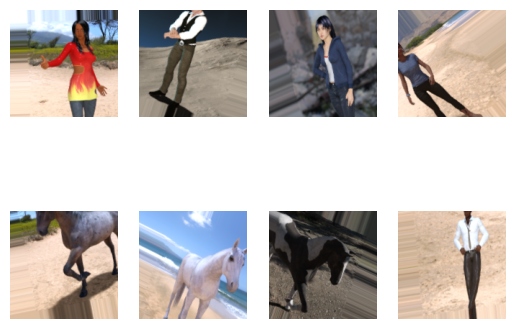

Example of the non-augmented dataset


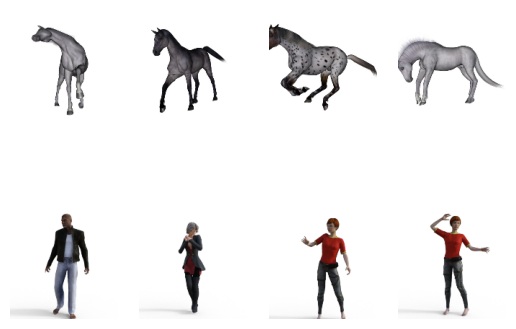

In [125]:
x,y = train_generator.next()
print('Example of the augmented dataset')
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.axis('off')
    image = x[i]
    plt.imshow(image)
plt.show()
print('Example of the non-augmented dataset')  
x,y = validation_generator.next()
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.axis('off')
    image = x[i]
    plt.imshow(image)
plt.show()

   

From looking at the images, One can notice that the validation images are centered in the middle and have no background. Whereas the training images have a background and have been augmented

Training the model

In [85]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 100,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/100
21/21 - 28s - loss: 0.2767 - accuracy: 0.9114 - val_loss: 0.0094 - val_accuracy: 0.9961
Epoch 2/100
21/21 - 26s - loss: 0.0290 - accuracy: 0.9873 - val_loss: 0.0254 - val_accuracy: 0.9883
Epoch 3/100
21/21 - 26s - loss: 0.0287 - accuracy: 0.9903 - val_loss: 0.0097 - val_accuracy: 0.9961
Epoch 4/100
21/21 - 29s - loss: 0.0566 - accuracy: 0.9825 - val_loss: 0.0070 - val_accuracy: 0.9961
Epoch 5/100
21/21 - 27s - loss: 0.0074 - accuracy: 0.9961 - val_loss: 0.0041 - val_accuracy: 0.9961
Epoch 6/100

Reached 99.9% accuracy so cancelling training!
21/21 - 28s - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.0071 - val_accuracy: 0.9961


**99.61%** accuracy reached on the validation set.
let us test some images now


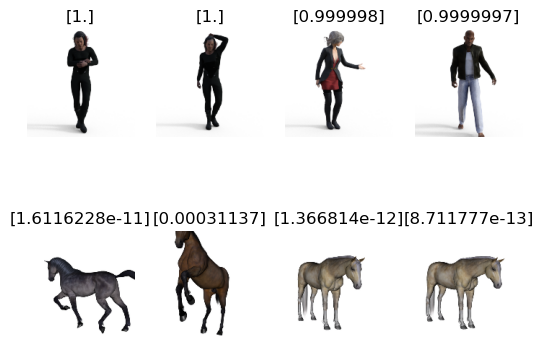

In [129]:
x,y = validation_generator.next()
hist = model.predict(x)
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.title(hist[i])
    plt.axis('off')
    image = x[i]
    plt.imshow(image)
plt.show()

let us find the images where the model is wrong

Found 256 images belonging to 2 classes.
[166]


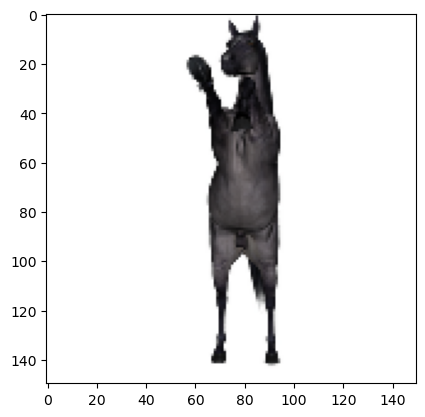

In [152]:
validation_generator =  validation_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 256,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))  
x,y = validation_generator.next()
predictions = model.predict(x)

predictions = np.rint(predictions).astype(int)

#finding index of the wrong predictions
wrong = []
for i in range(len(y)):
    if y[i] != predictions[i]:
        wrong.append(i)
print(wrong)
#printing the images in the wrong position
for j in wrong:
    image = x[j]
    plt.imshow(image)
    plt.show()
    

The above image may have been classified wrongly because it is standing in a upright postion like a human. To increase the accuracy of the model, training the model with more pictures of standing horses might be a viable option. 
Other than that, the model has an validation accuracy above 99%

This brings us to the end of the notebook. Happy Learning :)